# Measuring metallicity

The XGA LTR pipeline was run with the metallicity frozen at 0.3 $Z_{\odot}$, which was mainly for the practical reason that constraining metallicity along with temperature requires more photons, and we are somewhat photon starved here. 

In this notebook we will attempt to put a constraint on the global metallicity values by allowing them to vary in the spectral fits for the groups. 

## <font color=#FF0000>Notes to self</font>
* <font color=#FF0000>The 19670 A and B systems need some coddling</font>

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 40
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.xspec import single_temp_apec, single_temp_apec_profile

%matplotlib inline

## Reading the results file - $R_{500}$ and $R_{2500}$

As we have now run the luminosity-temperature-radius pipeline, we have access to measurements for the $R_{500}$ and $R_{2500}$ overdensity radii of these groups. This information is required for this notebook, so rather than read the original sample file we read in the results file (which also contains the original sample information):

In [2]:
samp_r500 = pd.read_csv('../outputs/results/ltr_r500_pipeline_results.csv')
samp_r500

,name,ra,dec,redshift,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+
0,19670A,150.25671,50.793942,0.134,565.230745,1.69940,0.301139,0.625748,1.923919e+42,3.586698e+41,4.989918e+41,4.100454e+42,7.430867e+41,9.649734e+41
1,19670B,150.21492,50.805014,0.134,590.155347,1.92186,0.236760,0.412706,4.771068e+42,2.548252e+41,3.382819e+41,1.056385e+43,9.319743e+41,1.084395e+42
2,12833,129.49680,44.248700,0.145,501.780182,1.41992,0.092045,0.125536,3.899479e+42,3.388153e+41,2.897504e+41,7.836917e+42,7.118439e+41,7.602804e+41
3,44858,230.11200,28.887750,0.127,726.221353,2.65845,0.234188,0.275686,2.566063e+43,1.004189e+42,1.104279e+42,6.352387e+43,4.070900e+42,3.823138e+42
4,PHL1811,328.76992,-9.588805,0.077,563.093086,1.68634,0.058023,0.070412,7.743633e+42,3.934662e+41,2.703076e+41,1.746595e+43,1.121958e+42,8.685135e+41


In [3]:
samp_r2500 = pd.read_csv('../outputs/results/ltr_r2500_pipeline_results.csv')
samp_r2500

,name,ra,dec,redshift,r2500,Tx2500,Tx2500-,Tx2500+,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+
0,19670A,150.25671,50.793942,0.134,229.549742,1.44342,0.418233,0.794367,2.921256e+41,1.848456e+41,1.648231e+41,5.906510e+41,3.578155e+41,4.199029e+41
1,19670B,150.21492,50.805014,0.134,276.657453,3.23768,0.660389,0.875739,1.750286e+42,2.128867e+41,1.904279e+41,4.686904e+42,6.914031e+41,8.544892e+41
2,12833,129.49680,44.248700,0.145,226.670867,1.42136,0.091381,0.118683,2.250820e+42,1.516062e+41,2.161923e+41,4.525233e+42,4.464786e+41,4.542320e+41
3,44858,230.11200,28.887750,0.127,317.285494,2.58898,0.182149,0.199412,1.309734e+43,4.919890e+41,4.827326e+41,3.210352e+43,1.479570e+42,1.725091e+42
4,PHL1811,328.76992,-9.588805,0.077,257.628544,1.73804,0.067516,0.072468,5.564601e+42,3.559554e+41,2.093395e+41,1.265809e+43,7.805432e+41,4.518125e+41


## Defining a ClusterSample

This sets up a ClusterSample with the information we have about our galaxy groups - we make use of the $R_2500$ and $R_{500}$s that we measured using the XGA LTR pipeline, as well as the positions and redshifts that we already had. The XGA LTR pipeline actually returns a ClusterSample object, but as that was run in a different notebook we must re-declare the object.

As a part of the ClusterSample setup, as the `load_fits` argument is set to True, all the spectral fits that were performed as a part of the pipeline will be loaded back into memory. We are centered on the original input RA-Dec coordinates, rather than on peak coordinates measured by XGA (controlled by `use_peak=False`):

In [4]:
est_ra = samp_r500['ra'].values
est_dec = samp_r500['dec'].values
redshift = samp_r500['redshift'].values
name = samp_r500['name'].values
r500 = Quantity(samp_r500['r500'].values, 'kpc')
r2500 = Quantity(samp_r2500['r2500'].values, 'kpc')

srcs = ClusterSample(est_ra, est_dec, redshift, name, r500=r500, r2500=r2500, load_fits=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.5, use_peak=False)
# This just shows any warnings (i.e. non-fatal issues) that occured during the setup process
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:237: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'19670A': ['There are 1 alternative matches for observation 0861080101, associated with source 19670A'],
 '19670B': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670B. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 'PHL1811': ["PHL1811 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"]}

## Measuring metallicity

Here we run single temperature absorbed APEC fits, with metallicity allowed to vary freely, in an attempt to constrain the enrichment of the intra-group medium. Initially the measurement is made within the $R_{500}$ region.

<font color=#FF0000>You may notice that 1 kpc is added to the $R_{500}$; this is because of an unintended XGA behaviour where spectral model fits with different settings cannot be stored, and we already have a fit to the $R_{500}$ region from the LTR pipeline.</font>

### $R_{500}$

In [5]:
single_temp_apec(srcs, srcs.r500+Quantity(1, 'kpc'), freeze_met=False, one_rmf=False)

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")


We iterate through the groups in the sample, and display the measured metallicity. The second and third entries in each metallicity array are the minus and plus uncertainties respectively, and the metallicities are in units of $Z_{\odot}$:

In [6]:
for src in srcs:
    print(src.name, '-', src.get_results(src.r500+Quantity(1, 'kpc'), 'constant*tbabs*apec', par='Abundanc'))

19670A - [0.12479    0.07500681 0.14597112]
19670B - [0.0772103  0.05030935 0.08277188]
12833 - [0.20204    0.06943387 0.10284795]
44858 - [0.429264   0.11583131 0.14591843]
PHL1811 - [0.283883   0.05357889 0.05844808]


### $R_{2500}$ and $R_{2500}$-$R_{500}$

Here I make use of XGA annular spectra to measure the metallicity within the $R_{2500}$ region, as well as the $R_{2500}$-$R_{500}$ region. Using annular spectra for $R_{2500}$ is a better choice, because the background annulus is automatically set as [1.05-1.5]$R_{\rm{out}}$.

Firstly, the radii are defined:

In [7]:
cheese = Quantity(1, 'kpc')
rads = [Quantity([Quantity(0, 'kpc'), src.r2500 + cheese, src.r500 + cheese]) for src in srcs]
rads

[<Quantity [  0.        , 230.54974249, 566.23074518] kpc>,
 <Quantity [  0.        , 277.65745251, 591.15534731] kpc>,
 <Quantity [  0.        , 227.67086712, 502.78018217] kpc>,
 <Quantity [  0.        , 318.28549446, 727.22135254] kpc>,
 <Quantity [  0.        , 258.62854384, 564.09308567] kpc>]

Then the annular spectra are generated and have the spectral fits performed:

In [8]:
single_temp_apec_profile(srcs, rads, freeze_met=False, one_rmf=False)

Then we can take a quick look at the values. As we might expect, they are not particularly well constrained, and don't tell us too much:

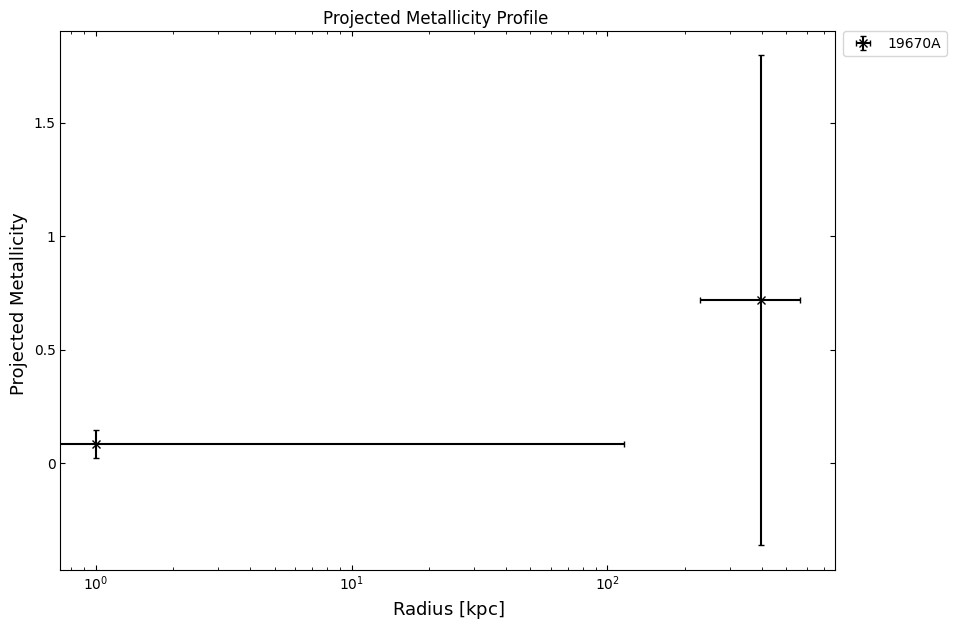

[0.0869611 0.717419 ]
[0.06221004 1.079037  ]



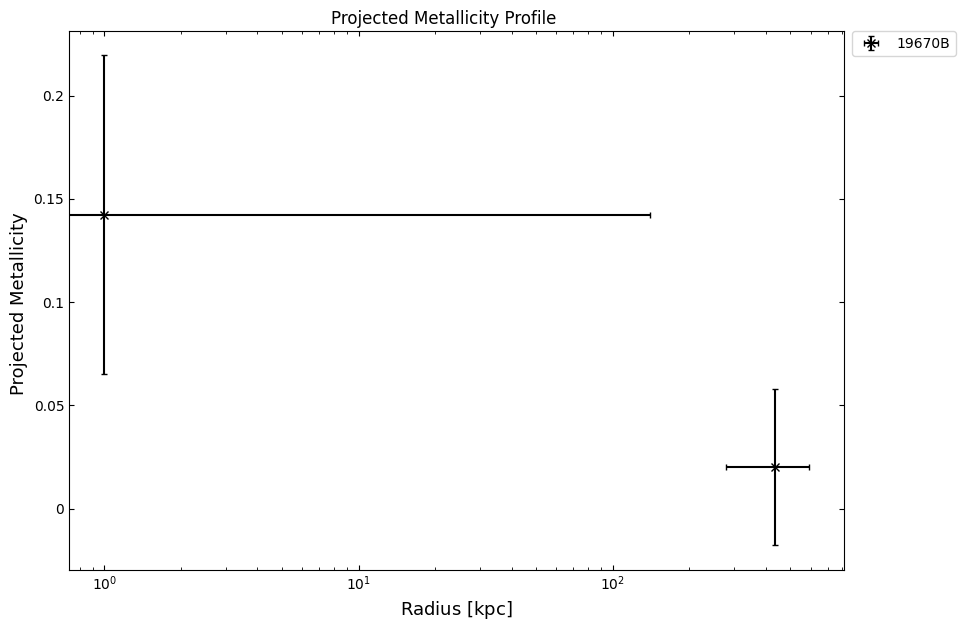

[0.142379  0.0199575]
[0.07708789 0.03780566]



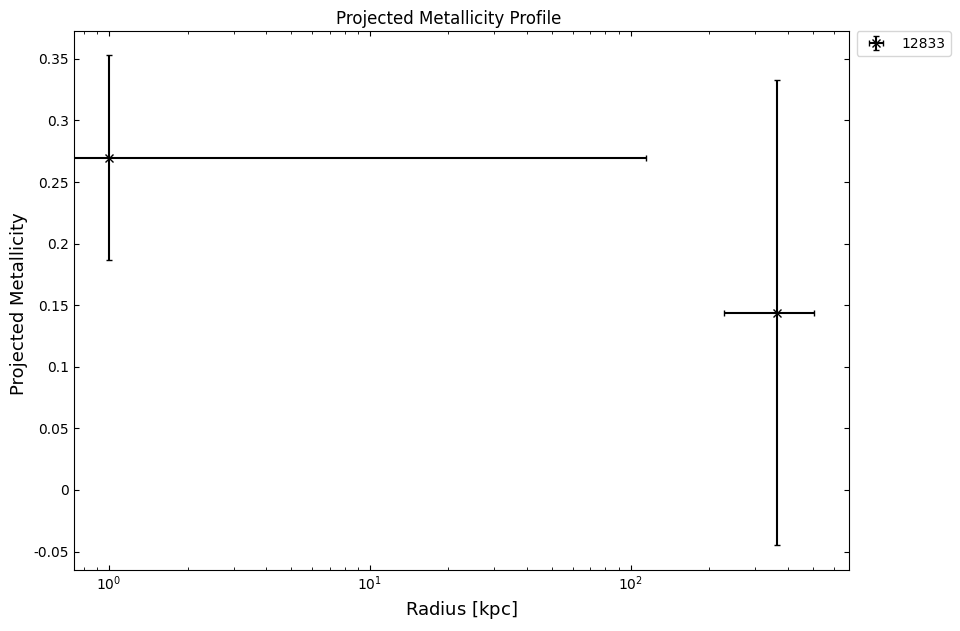

[0.269781 0.143997]
[0.08291473 0.18906793]



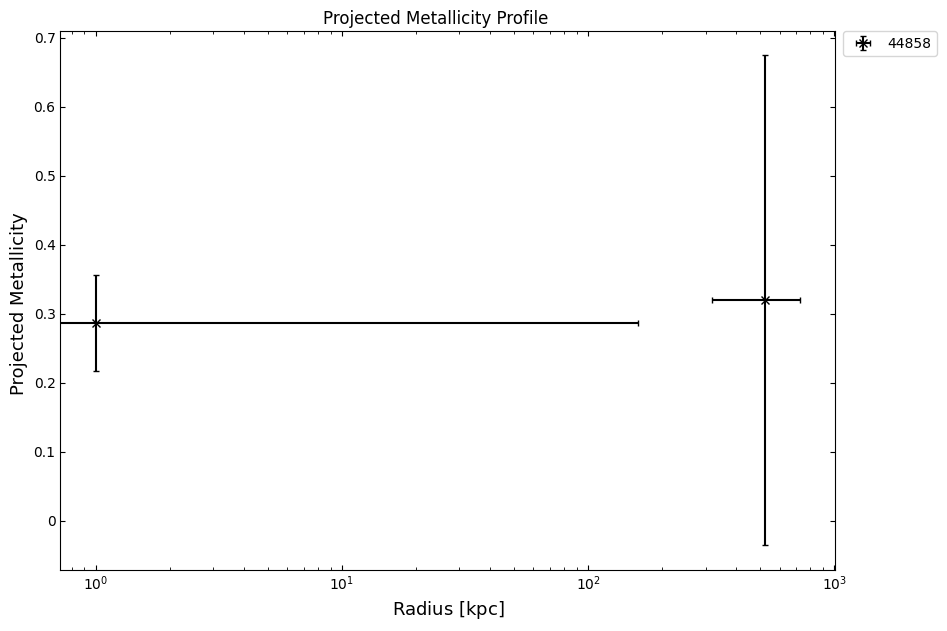

[0.287165 0.319542]
[0.06970826 0.35508054]



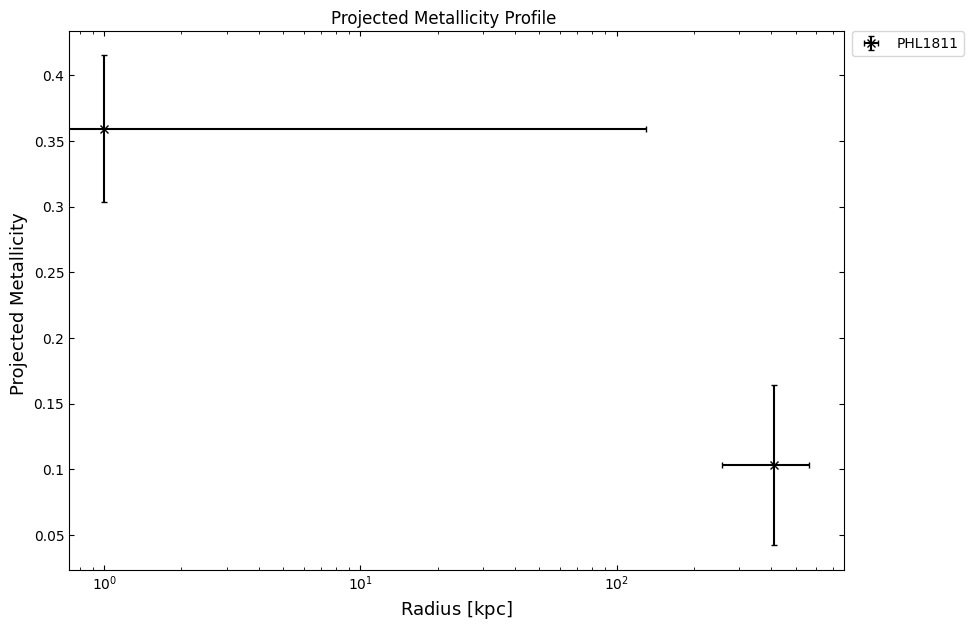

[0.359184 0.103079]
[0.05590876 0.06102372]



In [9]:
for src in srcs:
    m_prof = src.get_profiles('combined_1d_proj_metallicity')
    m_prof.view(yscale='linear')
    print(m_prof.values)
    print(m_prof.values_err) 
    print('')